In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv(r'C:\Users\Rakhat\Documents\dl\age_gender.csv')

## Converting pixels into numpy array
data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,"[129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 133..."
1,1,2,0,20161219222752047.jpg.chip.jpg,"[164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175...."
2,1,2,0,20161219222832191.jpg.chip.jpg,"[67.0, 70.0, 71.0, 70.0, 69.0, 67.0, 70.0, 79...."
3,1,2,0,20161220144911423.jpg.chip.jpg,"[193.0, 197.0, 198.0, 200.0, 199.0, 200.0, 202..."
4,1,2,0,20161220144914327.jpg.chip.jpg,"[202.0, 205.0, 209.0, 210.0, 209.0, 209.0, 210..."


In [3]:
print('Total rows: {}'.format(len(data)))
print('Total columns: {}'.format(len(data.columns)))

Total rows: 23705
Total columns: 5


In [4]:
## normalizing pixels data
data['pixels'] = data['pixels'].apply(lambda x: x/255)

## calculating distributions
age_dist = data['age'].value_counts()
ethnicity_dist = data['ethnicity'].value_counts()
gender_dist = data['gender'].value_counts().rename(index={0:'Male',1:'Female'})

def ditribution_plot(x,y,name):
    fig = go.Figure([
        go.Bar(x=x, y=y)
    ])

    fig.update_layout(title_text=name)
    fig.show()

In [8]:
X = np.array(data['pixels'].tolist())
print(X.shape)
## Converting pixels from 1D to 3D
X = X.reshape(X.shape[0],48,48,1)

(23705, 2304)


In [9]:
import numpy
c = numpy.zeros([300, 224, 224, 1])
i = 0
for a in X:
    new_image = tf.image.resize_with_pad(
    a, 224, 224, method=tf.image.ResizeMethod.BILINEAR,
    antialias=False
    )
    if i < 300:
        c[i] = new_image
    i = i + 1
    

In [10]:
import numpy
d = numpy.zeros([300, 224, 224, 3])
i = 0
for a in c:
    stacked_img = np.repeat(a, repeats = 3, axis = -1)
    if i < 300:
        d[i] = stacked_img
    i = i + 1

In [11]:
print(d.shape)

(300, 224, 224, 3)


In [13]:
y = data['gender']
print(y.shape)
print(y[250])

(23705,)
0


In [14]:
z = []
for i in range(300):
    z.append(y[i])

In [15]:

X_train, X_test, y_train, y_test = train_test_split(
    d, z,test_size=0.22, random_state=37
)

In [16]:
IMAGE_SIZE = [224, 224]
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.layers import Dense, Conv2D, BatchNormalization, MaxPool2D, AveragePooling2D, Flatten, Input,GlobalAveragePooling2D
model_resnet50 = ResNet50(include_top = False, weights = "imagenet", input_shape = (224, 224, 3))

In [20]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import numpy as np
import os
import imutils
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras

In [17]:
model = keras.models.load_model(r'C:\Users\Rakhat\Downloads\resnet50_gender.h5')

In [18]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [21]:
with tf.device('cpu:0'):    
    with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer('conv5_block3_out') 
        iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(X_test)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
        heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1) 

In [22]:
# import the necessary packages
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()
    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
    def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,
                self.model.output])
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
# resize the heatmap to oringnal X-Ray image size
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
# normalize the heatmap
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
# return the resulting heatmap to the calling function
        return heatmap

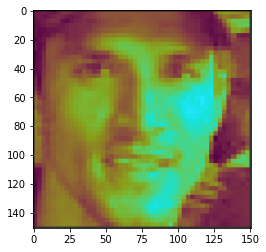

In [23]:
filename = r"C:\Users\Rakhat\Downloads\Heatmap2.png"
orignal = cv2.imread(filename)
plt.imshow(orignal)
plt.show()

In [24]:
orig = cv2.cvtColor(orignal, cv2.COLOR_BGR2RGB)
resized = cv2.resize(orig, (224, 224))
print(resized.shape)
dataXG = np.array(resized) / 255.0
dataXG = np.expand_dims(dataXG, axis=0)
print(dataXG.shape)


(224, 224, 3)
(1, 224, 224, 3)


In [28]:
preds = model.predict(dataXG)
i = np.argmax(preds[0])
print(i, preds)

0 [[0.07322873]]


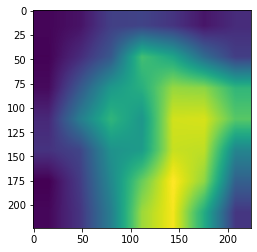

In [29]:
# Compute the heatmap based on step 3
cam = GradCAM(model=model, classIdx=i, layerName='conv5_block3_out') # find the last 4d shape "mixed10" in this case
heatmap = cam.compute_heatmap(dataXG)
#show the calculated heatmap
plt.imshow(heatmap)
plt.show()

(151, 151, 3) (151, 151, 3)


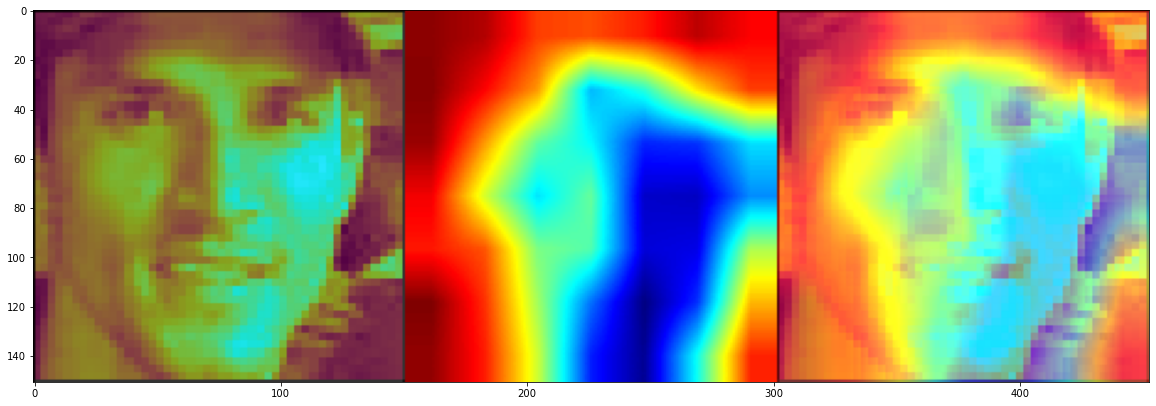

In [30]:
# Old fashioned way to overlay a transparent heatmap onto original image, the same as above
heatmapY = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
heatmapY = cv2.applyColorMap(heatmapY, cv2.COLORMAP_JET)  # COLORMAP_JET, COLORMAP_VIRIDIS, COLORMAP_HOT
imageY = cv2.addWeighted(heatmapY, 0.5, orignal, 1.0, 0)
original = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
print(heatmapY.shape, original.shape)
# draw the orignal x-ray, the heatmap, and the overlay together
output = np.hstack([original, heatmapY, imageY])
fig, ax = plt.subplots(figsize=(20, 18))
ax.imshow(np.random.rand(1, 99), interpolation='nearest')
plt.imshow(output)
plt.show()